#1. Імпорт і формування вибірки

Імпорт необхідних бібліотек

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import PIL.Image
import os
import random
import scipy.stats as st
from sklearn.metrics import mean_squared_error

Для псевдовипадкового формування вибірки зображень застосовано звичайну функцію random(), оскільки в її основі лежить генератор Мерсена (згідно з документацією). Стартове значення - 2.
Формування доволі тривіальне: спершу генерується 250 чисел із 25000, потім з архіву один раз вилучається папка mirflickr на Google Диск із зображеннями із номерами, відповідним цим 250-м числам, які у свою чергу конвертуються в numpy-масиви і в подальшому зберігаються в іншому масиві із назвою imgs. 


In [0]:
#generating random 250 numbers 
# rand_nums=[]
# random.seed(2)
# for i in range(251):
#   n = random.randint(1, 25000)
#   rand_nums.append(n)

#extracting images from archive into google drive
# def extractImgs(nums):
#   archive=ZipFile('/content/gdrive/My Drive/mirflickr25k.zip', 'r')
#   for i in nums:
#     path='mirflickr/im'+str(i)+'.jpg'
#     archive.extract(path, '/content/gdrive/My Drive/')
#   archive.close()

# extractImgs(rand_nums)

In [0]:
#converting images to arrays and appending them into list
def getImgs(path):
  imgs=[] 
  for img in os.listdir(path):
    imgs.append(np.array(PIL.Image.open(path+img)))
    
  return np.asarray(imgs)

imgs= getImgs('/content/drive/My Drive/mirflickr/')
print('Sampled {} RGB-images'.format(len(imgs)))

Sampled 250 RGB-images


# 2. Характеристики розподілу для зеленого каналу

Формування масиву, що містить значення яскравості пікселів зеленого каналу всієї вибірки зображень, а також двохвимірного масиву, що містить в собі масиви значень яскравості пікселів зеленого каналу кожного зображення.

In [0]:
#green_values contains green-pixel-intensities of all sample 
green_all = []
green_img_list=[]
for i in range(len(imgs)):
  img = imgs[i].flatten()
  n = len(img)
  k=len(green_all)
  for green in range(1, n, 3):
    green_all.append(img[green])
  green_img_list.append(np.array(green_all[k:k+int(np.floor(n/3))]))

green_all = np.array(green_all)
green_img_list = np.array(green_img_list)

In [0]:
green_img_binned_list =[]
green_all_binned = np.bincount(green_all)
for green_img in green_img_list:
  bincount = np.bincount(green_img)
  pixels_value_counts = np.zeros(256,dtype=int)
  pixels_value_counts[:bincount.shape[0]] = bincount
  img_dist = pixels_value_counts

  green_img_binned_list.append(img_dist)


Математичне очікування та дисперсія

In [0]:
expect_green = np.mean(green_all)
var_green = np.var(green_all)
print('Expected value and variance of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(expect_green, var_green))

Expected value and variance of pixel intensity of green channel of all 250 images are 101.77400161065259 and 5545.282938782499 respectively


Медіана та інтерквартальний розмах

In [0]:
median_green = np.median(green_all)

q75, q25 = np.percentile(green_all, [75 ,25])
iqr_green = q75 - q25
print('Median and interquartile range of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(median_green, iqr_green))

Median and interquartile range of pixel intensity of green channel of all 250 images are 96.0 and 126.0 respectively


Отже, значення, що лежать на відстані, більшій ніж півтора інтерквартильних діапазона від 1-го або ж 3-го квартиля, вважаються викидами. Проте розрахунки нижче вказують на те, що таких немає, оскільки q25-1.5iqr<0, а q75+1.5iqr>255.

In [0]:
print('We consider pixel intensity values to be outliers if they are below {} or above {}, but the values are far beyond valid range for pixel intensity.'.format(q25-1.5*iqr_green, q75+1.5*iqr_green))

We consider pixel intensity values to be outliers if they are below -156.0 or above 348.0, but the values are far beyond valid range for pixel intensity.


Коефіцієнти асиметрії та ексцесу (нормалізований)

In [0]:
skew_green = st.skew(green_all)
kurt_green = st.kurtosis(green_all)-3
print('Skewness and normalized kurtosis of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(skew_green, kurt_green))

Skewness and normalized kurtosis of pixel intensity of green channel of all 250 images are 0.3212877038756634 and -4.0173482995522924 respectively


Нормалізована гістограма значень яскравості пікселів

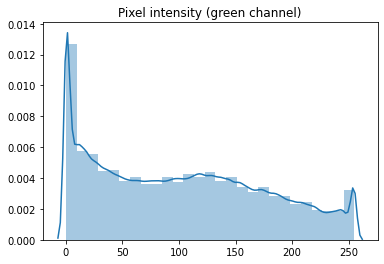

In [0]:
plt.title('Pixel intensity (green channel)')
sns.distplot(green_all, bins=27, norm_hist = True)

#3. Обробка отриманих гістограм

##a. Апроксимація гістограми

Провела апроксимацію гістограми вибірки всіх значень яскравості пікселів кривою нормального, Лапласового, Стьюдентового та бета- розподілу.

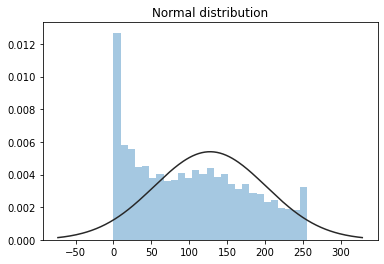

In [0]:
plt.title("Normal distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.norm,kde=False) 

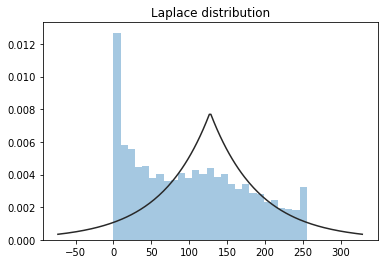

In [0]:
plt.title("Laplace distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.laplace,kde=False) 

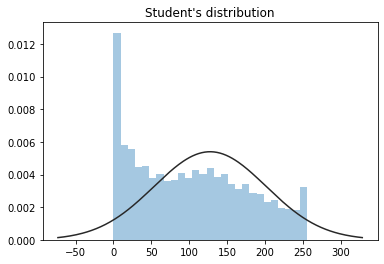

In [0]:
plt.title("Student's distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.t,kde=False) 

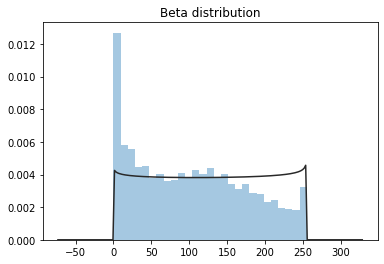

In [0]:
plt.title("Beta distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.beta,kde=False) 

##b.Визначення найкращого апроксимуючого розподілу (для кожної гістограми)

In [0]:
def get_best_approx(img_dist):
    space = np.linspace(0, 255, num=256)
    best_approx = None
    min_mse = 10**100
    
    for dist in [st.norm, st.t, st.laplace, st.beta]:
        pdf = dist.pdf(space,  *dist.fit(img_dist))
            
        mse = mean_squared_error(img_dist, pdf * img_dist.sum())
            
        if mse <= min_mse:
            min_mse = mse
            best_approx = dist
        
            
    return str(best_approx).split('.')[3].split(' ')[0].split('_')[0], min_mse

In [0]:
best_approx_dict = {img_idx+1: get_best_approx(green_img_binned_list[img_idx]) for img_idx in range(len(green_img_binned_list))}

In [0]:
best_dist_df = pd.DataFrame.from_dict(best_approx_dict,orient='index',columns=['Best distribution','MSE'])
best_dist_df.index.rename('Image',inplace=True)
best_dist_df

,Best distribution,MSE
Image,,
1,laplace,1.602494e+06
2,norm,7.294128e+05
3,t,9.334838e+05
4,laplace,1.124676e+06
5,norm,5.357496e+05
...,...,...
246,t,1.267409e+06
247,t,6.403343e+05
248,laplace,5.834728e+05


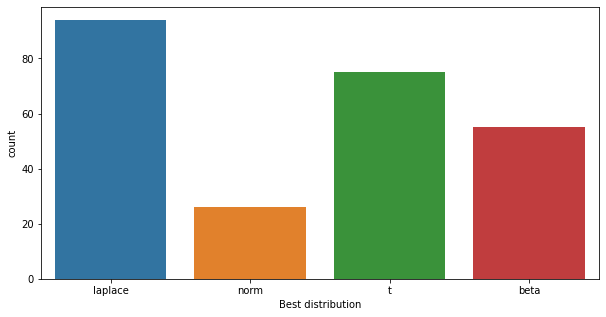

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(best_dist_df['Best distribution']);

#4. Багатовимірні гаусові моделі

## Формування векторів параметрів моделі

Функція формує вектори параметрів розподілу значень яскравості пікселів тестових зображень і повертає параметри багатовимірних гаусових моделей (математичне очікування, матрицю коваріацій) в залежності від групи векторів.

In [0]:
def model_params(img_list, mn=True, var=False, skw=False, kurt=False):
  needed_params = []
  mean_vec = [np.mean(img) for img in img_list]
  needed_params.append(mean_vec)
  mean = np.mean(mean_vec)
  cov = np.cov(mean_vec)
  if var: 
    var_vec = [np.var(img) for img in img_list]
    needed_params.append(var_vec)
    if skw:
      skw_vec = [st.skew(img) for img in img_list]
      needed_params.append(skw_vec)
      if kurt:
        kurt_vec = [st.kurtosis(img) for img in img_list]
        needed_params.append(kurt_vec)
    mean = np.mean(needed_params,axis=1)
    cov = np.cov(needed_params)
  return mean, cov

## Визначення параметрів і графічне відображенні відповідних моделей

i) Математичне очікування

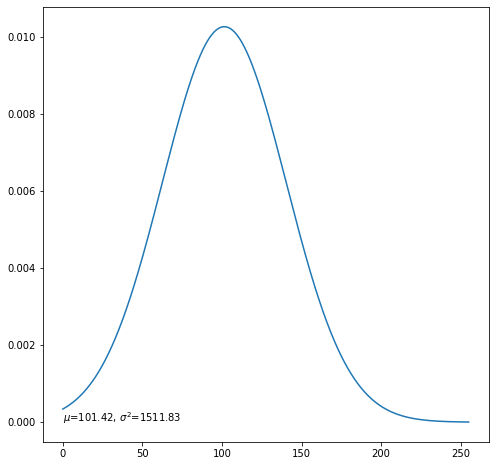

In [0]:
mean_i = model_params(green_img_list)[0]
cov_i = model_params(green_img_list)[1]

x = np.linspace(0,255,5100)
y = st.norm.pdf(x,mean_i,cov_i**0.5)

plt.figure(figsize=(8,8))
plt.plot(x,y)
plt.text(0.3, 0, f'$\mu$={mean_i:.2f}, $\sigma^2$={cov_i:.2f}');

ii) Математичне очікування та дисперсія

Mean vector:
[ 101.41725486 4029.99573068],
Covariance matrix:
[[1.51183214e+03 1.06073339e+04]
 [1.06073339e+04 4.20431174e+06]]


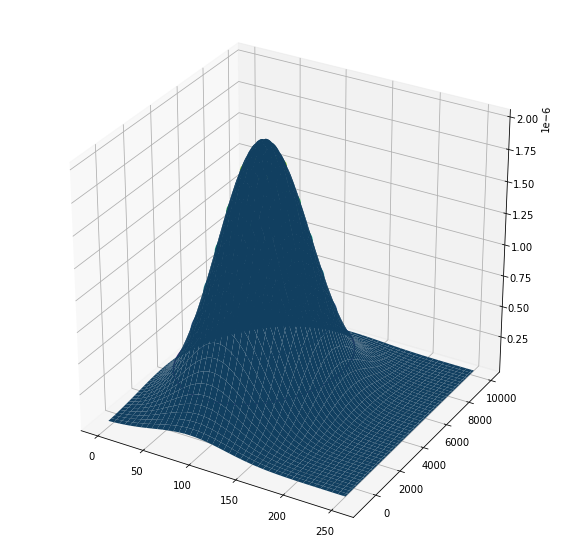

In [121]:
mean_ii = model_params(green_img_list, var=True)[0]
cov_ii = model_params(green_img_list,var=True)[1]
print('Mean vector:\n{},\nCovariance matrix:\n{}'.format(mean_ii, cov_ii))

x,y = np.mgrid[0:255, -1000:10000]
space = np.empty(x.shape+(2,))
space[:,:,0]=x
space[:,:,1]=y
z = st.multivariate_normal.pdf(space,mean_ii,cov_ii)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)

plt.contour(x,y,z)
plt.show()

iii) Математичне очікування, дисперсія та коефіцієнт асиметрії

Mean vector:
[1.01417255e+02 4.02999573e+03 4.32624092e-01],
Covariance matrix:
[[ 1.51183214e+03  1.06073339e+04 -3.17161316e+01]
 [ 1.06073339e+04  4.20431174e+06 -2.70671303e+02]
 [-3.17161316e+01 -2.70671303e+02  9.40015945e-01]]


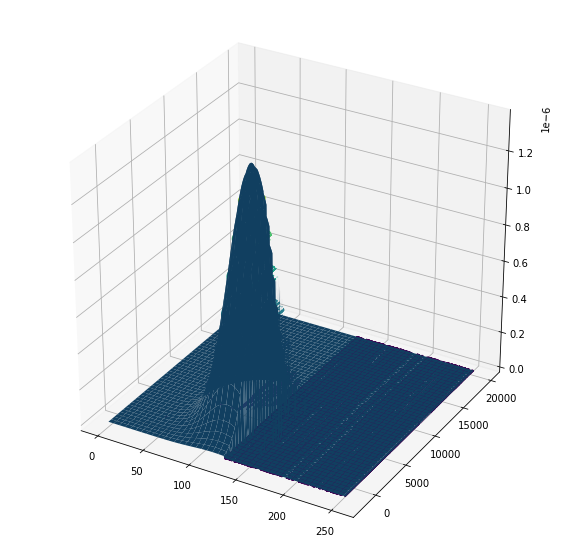

In [122]:
mean_iii = model_params(green_img_list, var=True, skw=True)[0]
cov_iii = model_params(green_img_list,var=True, skw=True)[1]
print('Mean vector:\n{},\nCovariance matrix:\n{}'.format(mean_iii, cov_iii))

x,y = np.mgrid[0:255, -2000:20000]
space = np.empty(x.shape+(3,))
space[:,:,0]=x
space[:,:,1]=y
z = st.multivariate_normal.pdf(space,mean_iii,cov_iii)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)

plt.contour(x,y,z)
plt.show()

iv) Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу

Mean vector:
[1.01417255e+02 4.02999573e+03 4.32624092e-01 4.57618704e-01],
Covariance matrix:
[[ 1.51183214e+03  1.06073339e+04 -3.17161316e+01 -5.46383876e+01]
 [ 1.06073339e+04  4.20431174e+06 -2.70671303e+02 -3.27512736e+03]
 [-3.17161316e+01 -2.70671303e+02  9.40015945e-01  2.20800721e+00]
 [-5.46383876e+01 -3.27512736e+03  2.20800721e+00  1.49354792e+01]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  del sys.path[0]


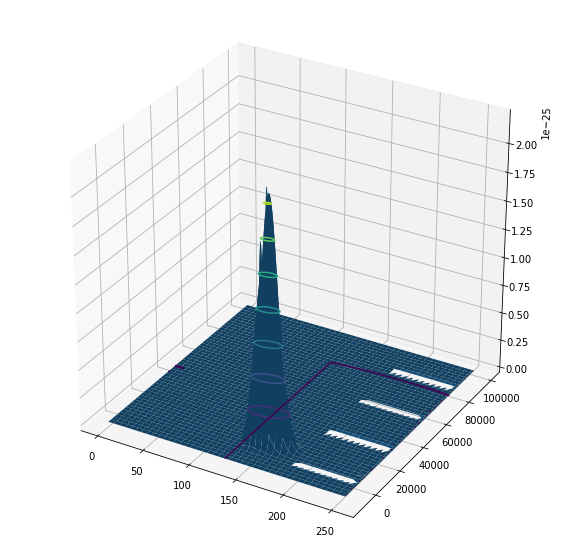

In [129]:
mean_iv = model_params(green_img_list, var=True, skw=True, kurt=True)[0]
cov_iv = model_params(green_img_list,var=True, skw=True, kurt=True)[1]
print('Mean vector:\n{},\nCovariance matrix:\n{}'.format(mean_iv, cov_iv))

x,y = np.mgrid[0:255, -10000:100000]
space = np.empty(x.shape+(4,))
space[:,:,0]=x
space[:,:,1]=y
z = st.multivariate_normal.pdf(space,mean_iv,cov_iv)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)

plt.contour(x,y,z)
plt.show()

# Додаткові завдання (Murphy)

## 4.2

Uncorrelated and Gaussian does not imply independent unless jointly Gaussian.

Let X ∼ N (0, 1) and Y = W X, where p(W = −1) = p(W = 1) = 0.5. It is clear that X and Y are
not independent, since Y is a function of X.

**a. Show Y ∼ N (0, 1).**

Визначимо функцію щільності p(Y).

Оскільки за умовою Y=WX, то p(Y) = p(WX) = a) p(X), W=1 або b) p(-X), W=-1.

Але
$p(-X) = \frac{1}{{\sqrt {2\pi }}}e^{\frac{-(-x)^2}{2}} = p(X)$, тобто функція щільності p(X) - парна, тому p(Y)=p(X), що означає, що випадкову величину Y характеризує та сама функція щільності, що і X ~ N(0, 1). Отже, Y ~ N(0, 1). 







**b.Show cov [X, Y]=0. Thus X and Y are uncorrelated but dependent, even though they are Gaussian.**

**Hint**: use the definition of covariance
cov[X, Y] = E[XY] − E [X]E[Y]

and the rule of iterated expectation
E [XY] = E [E [XY|W]] 

cov[X, Y] = E[XY] − E [X]E[Y] = |за правилом повного математичного сподівання (iterated expectation) і оскільки E[X]=E[Y]=0, бо X, Y ~ N(0, 1)|= 0.5E[XY|W=1]+0.5E[XY|W=-1] = 0.5E[X*1*X] + 0.5E[X*(-1)*X] = 0.5(E[$X^2$] + E[$-X^2$]) = |лінійність математичного сподівання| =  0.5(E[$X^2$] - E[$X^2$]) = 0.

Отже, випадкові величини X і Y не корелюють, хоча є залежними і мають нормальний розподіл.